In [1]:
sc.install_pypi_package("pandas==1.2.2")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1649394251756_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 22.0.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [2]:
sc.install_pypi_package("matplotlib==3.1.1", "https://pypi.org/simple")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 22.0.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import * 
from nltk.corpus import stopwords

import pandas as pd
import string 
import re 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
review = spark.read.orc("hdfs:///NLP-orc/*.orc")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
review = review.drop("business_id","date","review_id","user_id","cool","funny","useful")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
review.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+
|stars|                text|
+-----+--------------------+
|  4.0|Ever wanted too j...|
|  5.0|Dry-aged bone-in ...|
|  5.0|I lived in Boston...|
|  3.0|Some good things ...|
|  4.0|Great place to gr...|
|  1.0|It's like the Wal...|
|  5.0|The food was incr...|
|  5.0|Haven't been so h...|
|  5.0|These guys helped...|
|  4.0|great service and...|
+-----+--------------------+
only showing top 10 rows

In [7]:
review.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8635403

In [7]:
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)

### Tokenizer

In [5]:
rgtoken = RegexTokenizer(inputCol="text",outputCol="words",pattern="\\W")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### stop word remover

In [6]:
stops = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
stopword_remover = StopWordsRemover(inputCol="words", outputCol="filtered")\
                    .setStopWords(stops)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Ngram

In [8]:
Unigram = NGram(n=1, inputCol="filtered", outputCol="UniGrams")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
Bigram = NGram(n=2, inputCol="filtered", outputCol="BiGrams")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
Trigram = NGram(n=3, inputCol="filtered", outputCol="TriGrams")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Pipeline

In [7]:
nlp_pipeline = Pipeline(stages=[rgtoken, stopword_remover,Unigram,Bigram,Trigram])
light_pipeline = nlp_pipeline.fit(review)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'rgtoken' is not defined
Traceback (most recent call last):
NameError: name 'rgtoken' is not defined



In [6]:
result = light_pipeline.transform(review)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'light_pipeline' is not defined
Traceback (most recent call last):
NameError: name 'light_pipeline' is not defined



In [13]:
result.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- UniGrams: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- BiGrams: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- TriGrams: array (nullable = true)
 |    |-- element: string (containsNull = false)

In [14]:
result.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|stars|                text|               words|            filtered|            UniGrams|             BiGrams|            TriGrams|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  4.0|Ever wanted too j...|[ever, wanted, to...|[wanted, bite, fu...|[wanted, bite, fu...|[wanted bite, bit...|[wanted bite full...|
|  5.0|Dry-aged bone-in ...|[dry, aged, bone,...|[dry, aged, bone,...|[dry, aged, bone,...|[dry aged, aged b...|[dry aged bone, a...|
|  5.0|I lived in Boston...|[i, lived, in, bo...|[lived, boston, y...|[lived, boston, y...|[lived boston, bo...|[lived boston yea...|
|  3.0|Some good things ...|[some, good, thin...|[good, things, al...|[good, things, al...|[good things, thi...|[good things alib...|
|  4.0|Great place to gr...|[great, place, to...|[great, place

In [22]:
#light_pipeline.save("s3://ashprojfinal/Ngram_pipeline/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
Ngram_pipe = PipelineModel.load("hdfs:///Ngram_pipe/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
Ngram_pipe_test = Ngram_pipe.transform(review)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
Ngram_pipe_test.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|stars|                text|               words|            filtered|            UniGrams|             BiGrams|            TriGrams|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  4.0|Ever wanted too j...|[ever, wanted, to...|[wanted, bite, fu...|[wanted, bite, fu...|[wanted bite, bit...|[wanted bite full...|
|  5.0|Dry-aged bone-in ...|[dry, aged, bone,...|[dry, aged, bone,...|[dry, aged, bone,...|[dry aged, aged b...|[dry aged bone, a...|
|  5.0|I lived in Boston...|[i, lived, in, bo...|[lived, boston, y...|[lived, boston, y...|[lived boston, bo...|[lived boston yea...|
|  3.0|Some good things ...|[some, good, thin...|[good, things, al...|[good, things, al...|[good things, thi...|[good things alib...|
|  4.0|Great place to gr...|[great, place, to...|[great, place

### Unique Ngram Count

In [11]:
unique_unigram = Ngram_pipe_test.select(explode("UniGrams").alias("unigram")).groupBy("unigram").count().orderBy(desc("count"), "unigram")
unique_unigram.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------+
|unigram|  count|
+-------+-------+
|   food|4411677|
|   good|4222370|
|  place|4066403|
|  great|3721926|
|   time|2944327|
|service|2882528|
|   nice|1548504|
|   love|1370791|
|  staff|1365744|
|  order|1353377|
+-------+-------+
only showing top 10 rows

In [12]:
unigram_plot = unique_unigram.limit(30).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

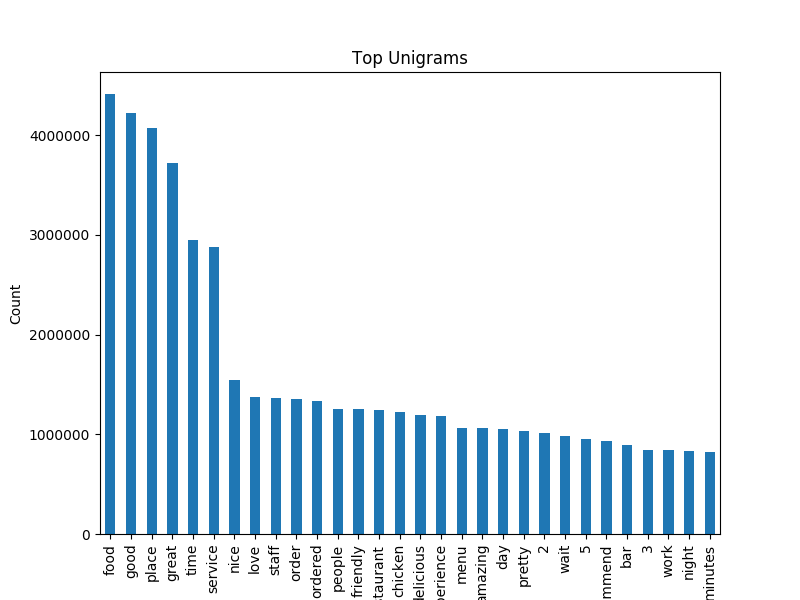

In [13]:
plt.clf()
unigram_plot.plot(kind='bar', x='unigram',y='count', legend=None, figsize=(8,6))
plt.title('Top Unigrams')
plt.xlabel('Unigram')
plt.ylabel('Count')

%matplot plt

In [14]:
unique_bigram = Ngram_pipe_test.select(explode("BiGrams").alias("bigram")).groupBy("bigram").count().orderBy(desc("count"), "bigram")
unique_bigram.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+------+
|          bigram| count|
+----------------+------+
|customer service|420058|
|highly recommend|327591|
|       food good|271209|
|     pretty good|226034|
|       ice cream|225064|
|     great place|200225|
|  staff friendly|186075|
|   great service|183457|
|      love place|179069|
|      great food|177961|
+----------------+------+
only showing top 10 rows

In [15]:
bigram_plot = unique_bigram.limit(30).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

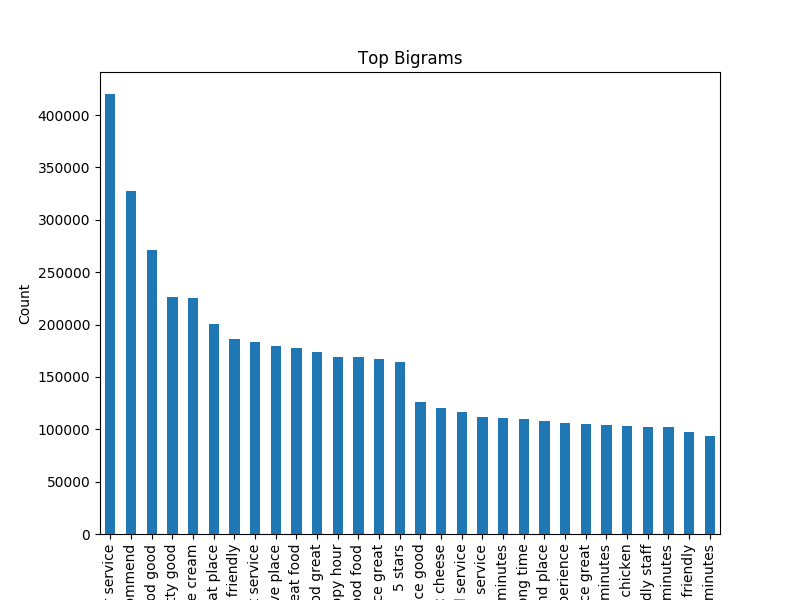

In [16]:
plt.clf()
bigram_plot.plot(kind='bar', x='bigram',y='count', legend=None, figsize=(8,6))
plt.title('Top Bigrams')
plt.xlabel('Bigram')
plt.ylabel('Count')

%matplot plt

In [17]:
unique_trigram = Ngram_pipe_test.select(explode("TriGrams").alias("trigram")).groupBy("trigram").count().orderBy(desc("count"), "trigram")
unique_trigram.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|             trigram|count|
+--------------------+-----+
|great customer se...|38078|
|highly recommend ...|30499|
|  food great service|29894|
|staff super friendly|26796|
|    great food great|26366|
|   food good service|25845|
|    food pretty good|24927|
|  service great food|22903|
|  sweet potato fries|22067|
|      love love love|21532|
+--------------------+-----+
only showing top 10 rows

In [18]:
trigram_plot = unique_trigram.limit(15).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

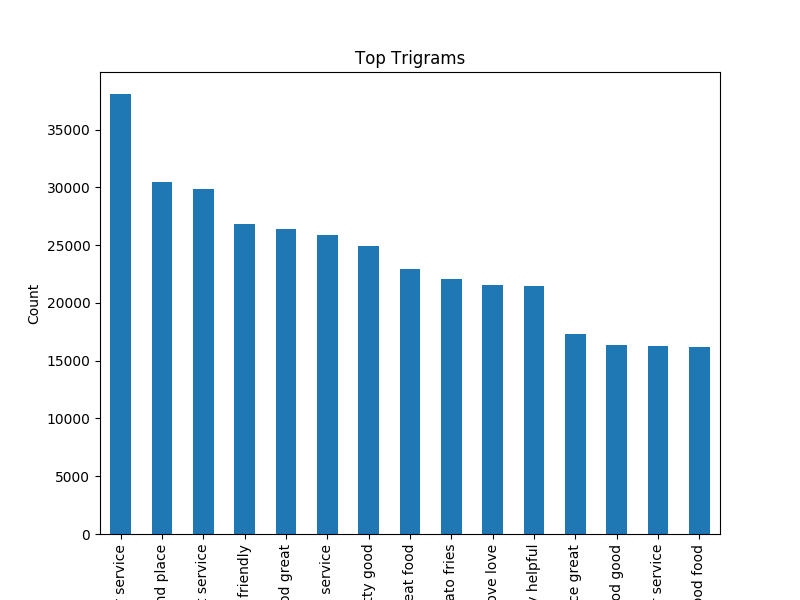

In [19]:
plt.clf()
trigram_plot.plot(kind='bar', x='trigram',y='count', legend=None, figsize=(8,6))
plt.title('Top Trigrams')
plt.xlabel('Trigram')
plt.ylabel('Count')

%matplot plt

## Filtered 1 star

In [20]:
one_star = Ngram_pipe_test.filter(col('stars')==1.0)
one_star.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|stars|                text|               words|            filtered|            UniGrams|             BiGrams|            TriGrams|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  1.0|It's like the Wal...|[it, s, like, the...|[walmart, sports,...|[walmart, sports,...|[walmart sports, ...|[walmart sports m...|
|  1.0|Well this place h...|[well, this, plac...|[place, decent, f...|[place, decent, f...|[place decent, de...|[place decent foo...|
|  1.0|I went to this pl...|[i, went, to, thi...|[place, birthday,...|[place, birthday,...|[place birthday, ...|[place birthday i...|
|  1.0|Ordered a fish sa...|[ordered, a, fish...|[ordered, fish, s...|[ordered, fish, s...|[ordered fish, fi...|[ordered fish san...|
|  1.0|The fact they got...|[the, fact, they,...|[fact, 1, sta

In [21]:
one_star_unigram = one_star.select(explode("UniGrams").alias("unigram")).groupBy("unigram").count().orderBy(desc("count"), "unigram").limit(20).toPandas()
one_star_bigram = one_star.select(explode("BiGrams").alias("bigram")).groupBy("bigram").count().orderBy(desc("count"), "bigram").limit(20).toPandas()
one_star_trigram = one_star.select(explode("TriGrams").alias("trigram")).groupBy("trigram").count().orderBy(desc("count"), "trigram").limit(20).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

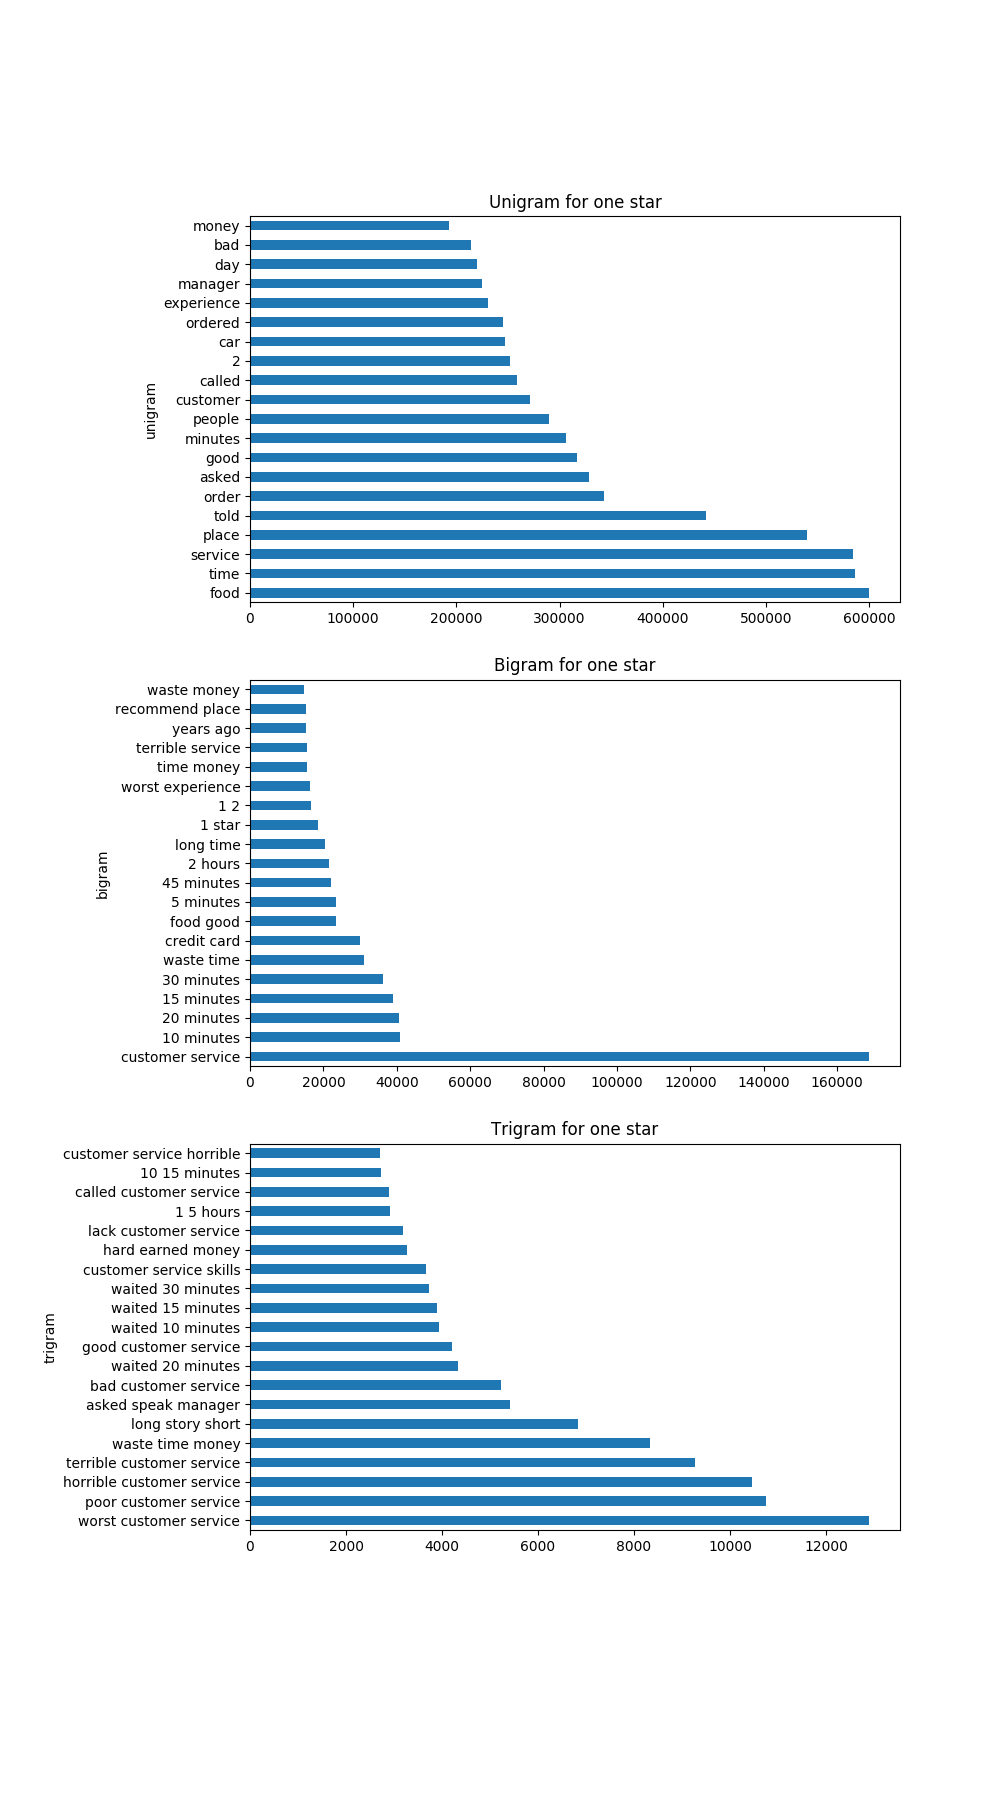

In [22]:
fig = plt.figure(constrained_layout=True)

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
plt.title('Top Bigrams')
one_star_unigram.plot(kind = 'barh', x='unigram', y='count', ax=ax1, title='Unigram for one star', legend=False, figsize=(10,18))
one_star_bigram.plot(kind = 'barh', x='bigram', y='count', ax=ax2, title='Bigram for one star', legend=False, figsize=(10,18))
one_star_trigram.plot(kind = 'barh', x='trigram', y='count', ax=ax3, title='Trigram for one star', legend=False, figsize=(10,18))
plt.gcf().subplots_adjust(bottom=0.15, left=0.25)
%matplot plt

## Filtered 2 star

In [23]:
two_star = Ngram_pipe_test.filter(col('stars')==2.0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
two_star_unigram = two_star.select(explode("UniGrams").alias("unigram")).groupBy("unigram").count().orderBy(desc("count"), "unigram").limit(20).toPandas()
two_star_bigram = two_star.select(explode("BiGrams").alias("bigram")).groupBy("bigram").count().orderBy(desc("count"), "bigram").limit(20).toPandas()
two_star_trigram = two_star.select(explode("TriGrams").alias("trigram")).groupBy("trigram").count().orderBy(desc("count"), "trigram").limit(20).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

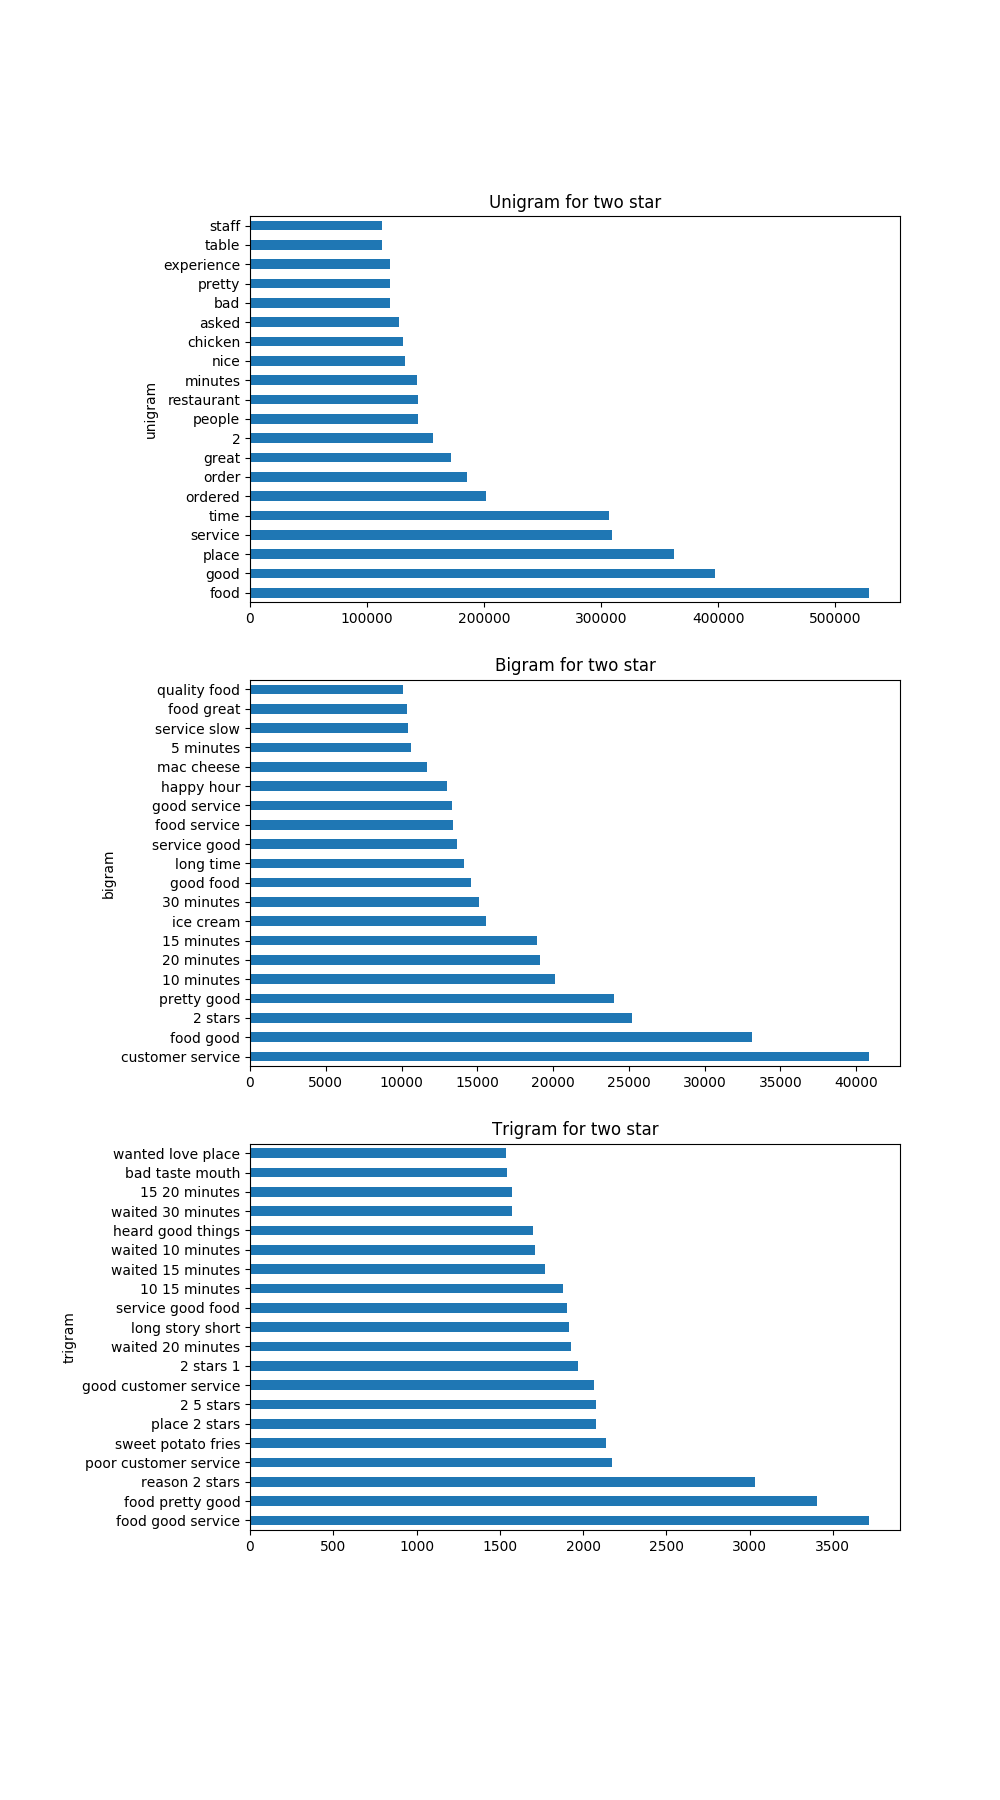

In [38]:
fig = plt.figure(constrained_layout=True)

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
plt.title('Top Bigrams')
two_star_unigram.plot(kind = 'barh', x='unigram', y='count', ax=ax1, title='Unigram for two star', legend=False, figsize=(10,18))
two_star_bigram.plot(kind = 'barh', x='bigram', y='count', ax=ax2, title='Bigram for two star', legend=False, figsize=(10,18))
two_star_trigram.plot(kind = 'barh', x='trigram', y='count', ax=ax3, title='Trigram for two star', legend=False, figsize=(10,18))
plt.gcf().subplots_adjust(bottom=0.15, left=0.25)
%matplot plt

## Filtered 3 star

In [29]:
three_star = Ngram_pipe_test.filter(col('stars')==3.0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
three_star_unigram = three_star.select(explode("UniGrams").alias("unigram")).groupBy("unigram").count().orderBy(desc("count"), "unigram").limit(20).toPandas()
three_star_bigram = three_star.select(explode("BiGrams").alias("bigram")).groupBy("bigram").count().orderBy(desc("count"), "bigram").limit(20).toPandas()
three_star_trigram = three_star.select(explode("TriGrams").alias("trigram")).groupBy("trigram").count().orderBy(desc("count"), "trigram").limit(20).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

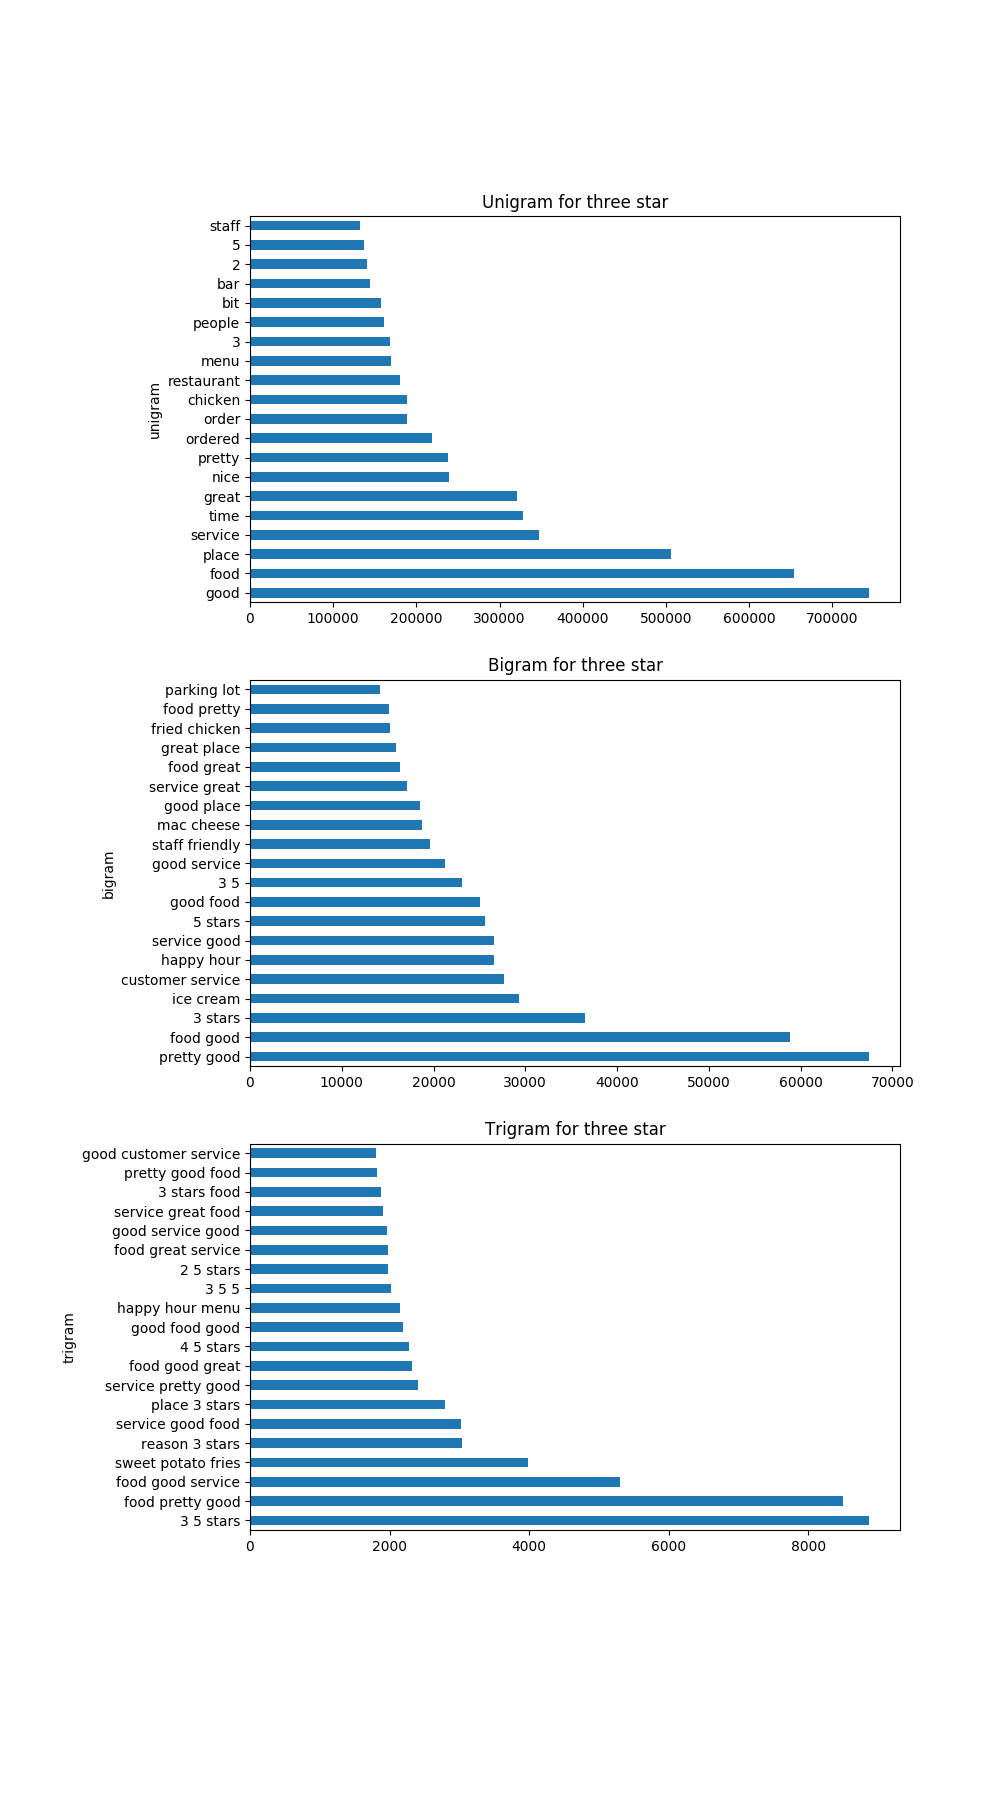

In [39]:
fig = plt.figure(constrained_layout=True)

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
plt.title('Top Bigrams')
three_star_unigram.plot(kind = 'barh', x='unigram', y='count', ax=ax1, title='Unigram for three star', legend=False, figsize=(10,18))
three_star_bigram.plot(kind = 'barh', x='bigram', y='count', ax=ax2, title='Bigram for three star', legend=False, figsize=(10,18))
three_star_trigram.plot(kind = 'barh', x='trigram', y='count', ax=ax3, title='Trigram for three star', legend=False, figsize=(10,18))
plt.gcf().subplots_adjust(bottom=0.15, left=0.25)
%matplot plt

## Filtered four star

In [32]:
four_star = Ngram_pipe_test.filter(col('stars')==4.0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
four_star_unigram = four_star.select(explode("UniGrams").alias("unigram")).groupBy("unigram").count().orderBy(desc("count"), "unigram").limit(20).toPandas()
four_star_bigram = four_star.select(explode("BiGrams").alias("bigram")).groupBy("bigram").count().orderBy(desc("count"), "bigram").limit(20).toPandas()
four_star_trigram = four_star.select(explode("TriGrams").alias("trigram")).groupBy("trigram").count().orderBy(desc("count"), "trigram").limit(20).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

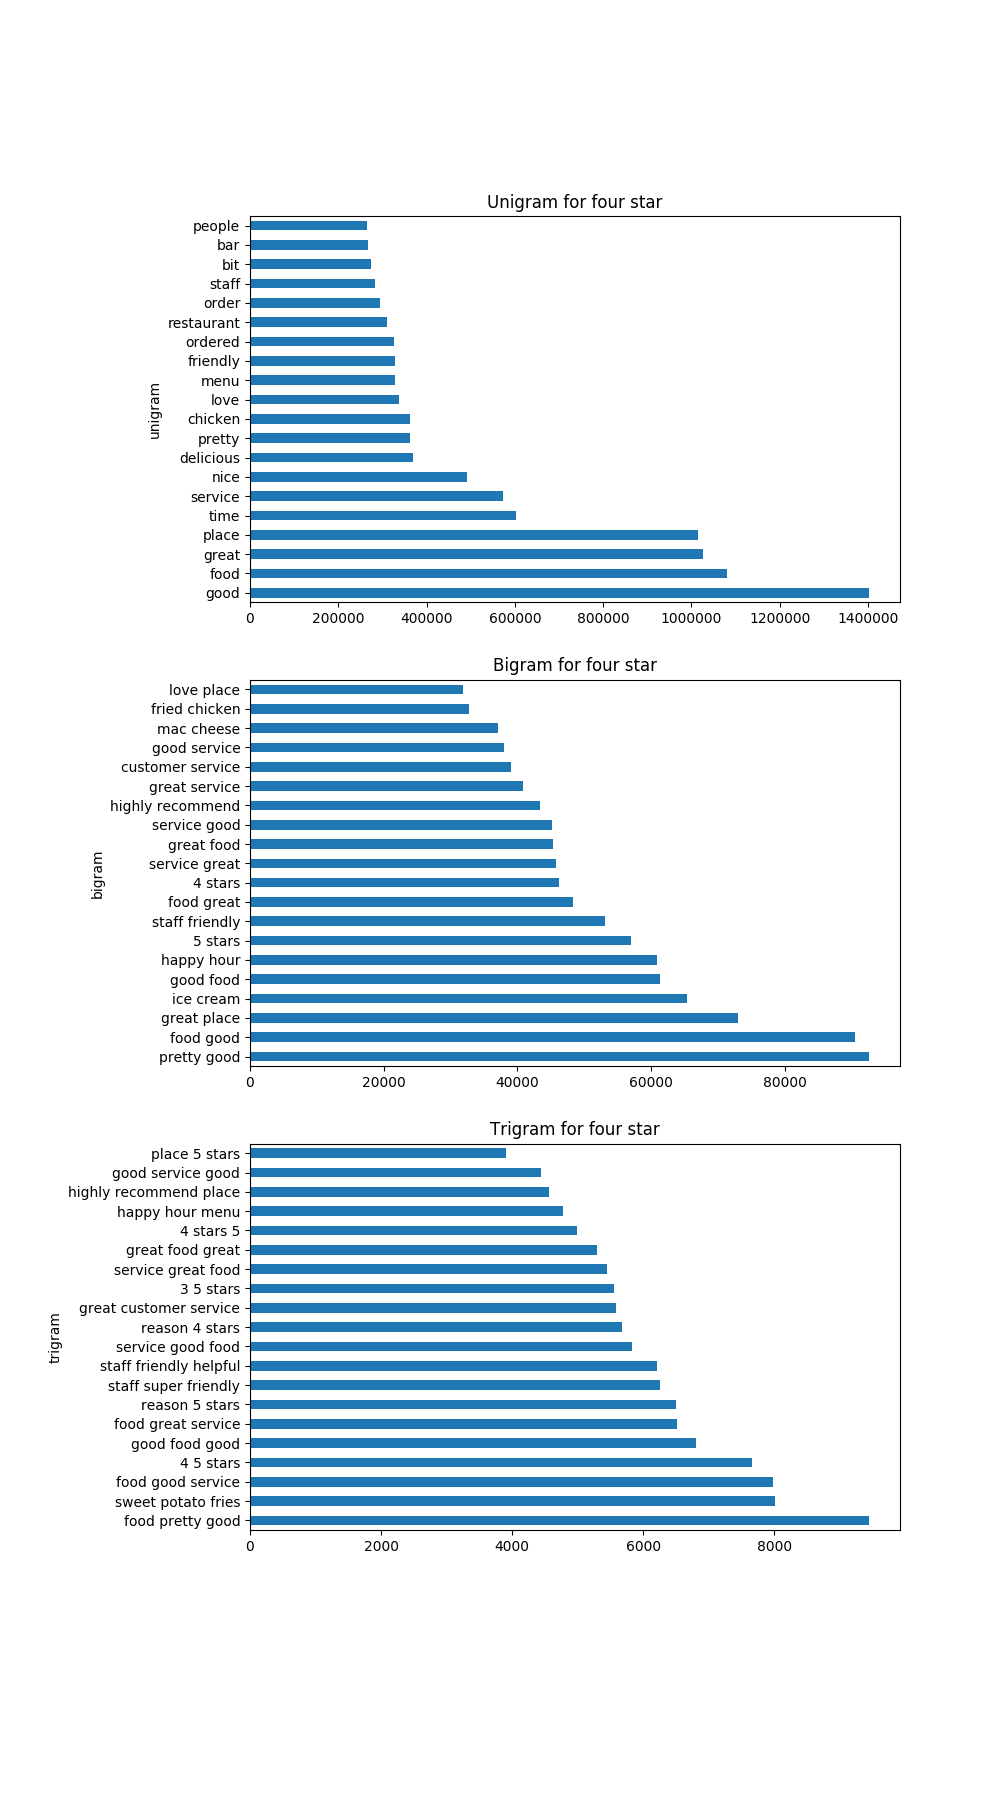

In [40]:
fig = plt.figure(constrained_layout=True)

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
plt.title('Top Bigrams')
four_star_unigram.plot(kind = 'barh', x='unigram', y='count', ax=ax1, title='Unigram for four star', legend=False, figsize=(10,18))
four_star_bigram.plot(kind = 'barh', x='bigram', y='count', ax=ax2, title='Bigram for four star', legend=False, figsize=(10,18))
four_star_trigram.plot(kind = 'barh', x='trigram', y='count', ax=ax3, title='Trigram for four star', legend=False, figsize=(10,18))
plt.gcf().subplots_adjust(bottom=0.15, left=0.25)
%matplot plt

## Filtered five star

In [35]:
five_star = Ngram_pipe_test.filter(col('stars')==5.0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
five_star_unigram = five_star.select(explode("UniGrams").alias("unigram")).groupBy("unigram").count().orderBy(desc("count"), "unigram").limit(20).toPandas()
five_star_bigram = five_star.select(explode("BiGrams").alias("bigram")).groupBy("bigram").count().orderBy(desc("count"), "bigram").limit(20).toPandas()
five_star_trigram = five_star.select(explode("TriGrams").alias("trigram")).groupBy("trigram").count().orderBy(desc("count"), "trigram").limit(20).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

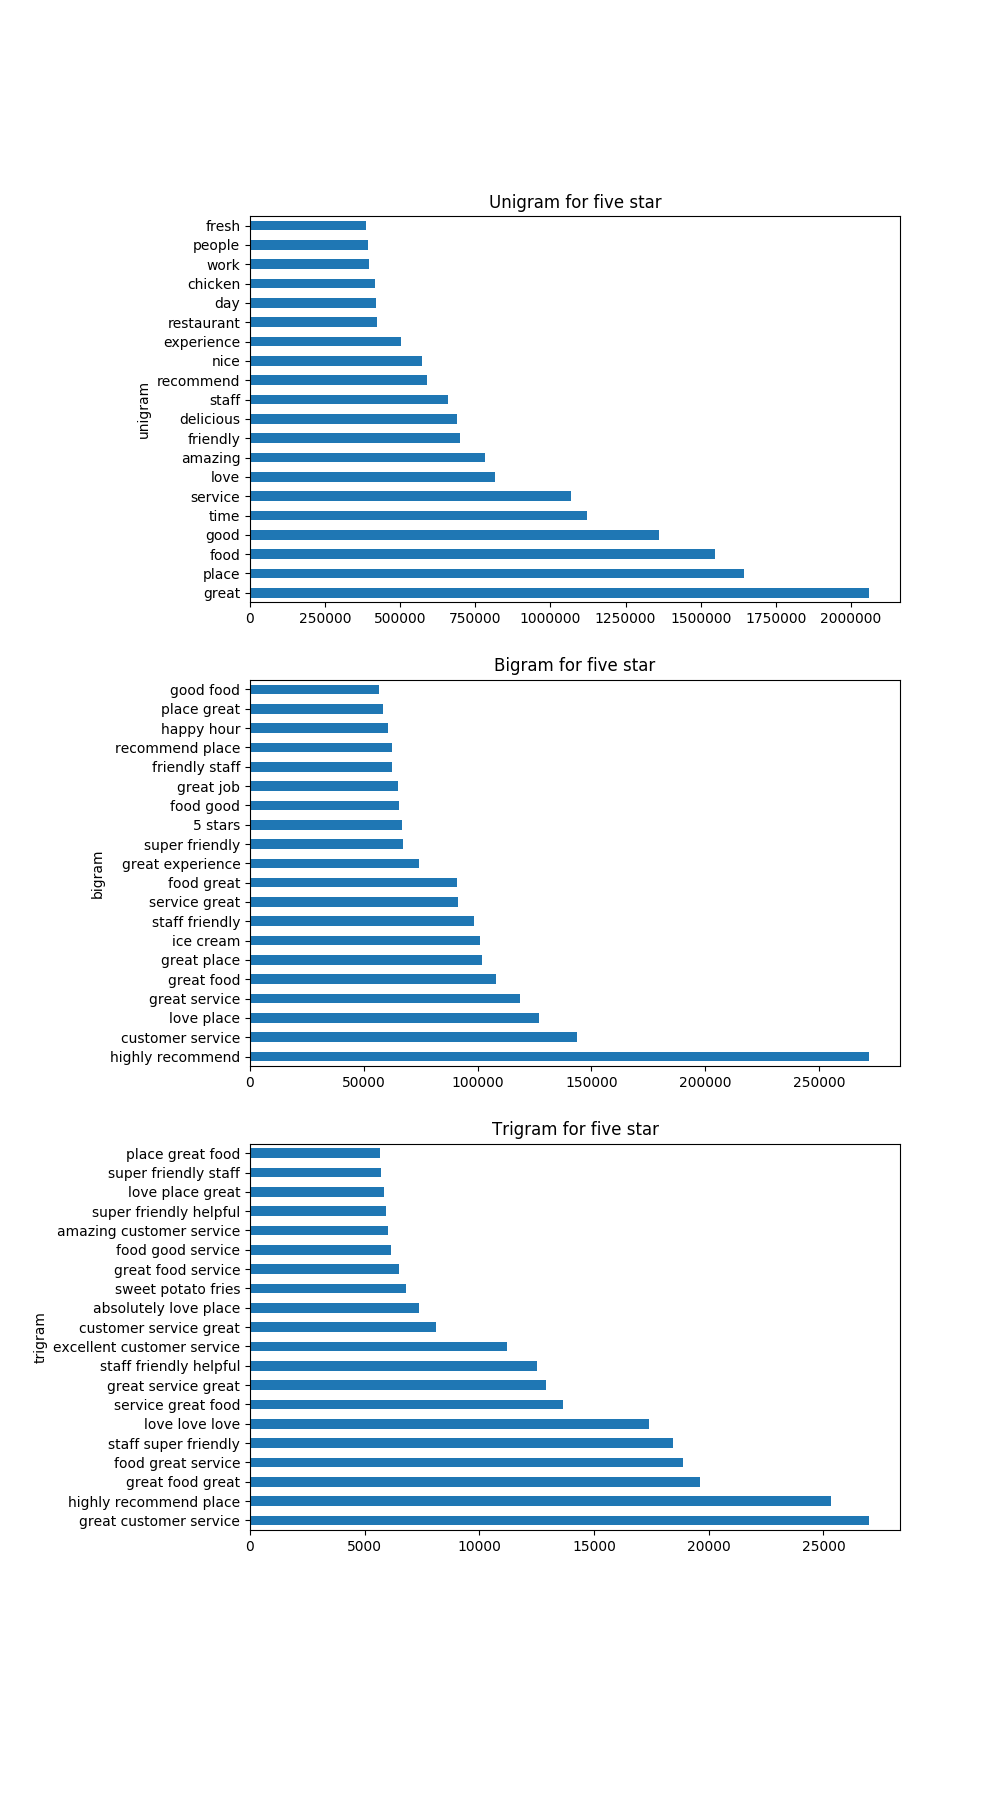

In [41]:
fig = plt.figure(constrained_layout=True)

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
plt.title('Top Bigrams')
five_star_unigram.plot(kind = 'barh', x='unigram', y='count', ax=ax1, title='Unigram for five star', legend=False, figsize=(10,18))
five_star_bigram.plot(kind = 'barh', x='bigram', y='count', ax=ax2, title='Bigram for five star', legend=False, figsize=(10,18))
five_star_trigram.plot(kind = 'barh', x='trigram', y='count', ax=ax3, title='Trigram for five star', legend=False, figsize=(10,18))
plt.gcf().subplots_adjust(bottom=0.15, left=0.25)
%matplot plt